# 3_3 index multimodal (messages)
* index `jinaai/JinaVDR`-`github-readme-retrieval-multilingual` dataset
* index 'text' + 'image' in 'messages' format

In [1]:
import os
import sys
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
print(parent_dir)
core_src_dir = os.path.join(parent_dir, "src/psiking-core")
print(core_src_dir)
sys.path.append(core_src_dir)

from datasets import load_dataset, load_from_disk
from tqdm import tqdm

from config import settings

/Users/id4thomas/github/psi-king
/Users/id4thomas/github/psi-king/src/psiking-core


# 1. Load Dataset
* `ko` split of `github-readme-retrieval-multilingual` 

In [2]:
ds = load_from_disk(
    os.path.join(
        settings.data_dir,
        'github-readme-retrieval-multilingual/data/ko'
    )
)

In [3]:
id_column = list(range(len(ds['test'])))
ds['test']=ds['test'].add_column(
    name='id',
    column=id_column
)

In [4]:
# ds['test'][0]

# 2. Prepare PSIKing Documents
* dataset text -> PSIKing Document

In [5]:
from psiking.core.base.schema import ImageNode, Document

In [6]:
def convert_image(img):
    orig_format = img.format or "PNG"
    img = img.convert("RGB")
    img.format=orig_format
    return img


def prepare_documents(x):
    # print(x)
    documents = []
    for i in range(len(x['id'])):
        node = ImageNode(
            image_resource=convert_image(x['image'][i]),
            # image_resource=x['image'][i],
            text_resource=x['text_description'][i],
            metadata={
                'docid': x['id'][i]
            }
        )
        document = Document(
            nodes=[node],
            metadata={
                'docid': x['id'][i]
            }
        )
        documents.append(document.to_dict())
    return {'doc': documents}

In [7]:
collection = ds.map(
    function=prepare_documents,
    batched=True,
    batch_size=16,
    num_proc=8
)

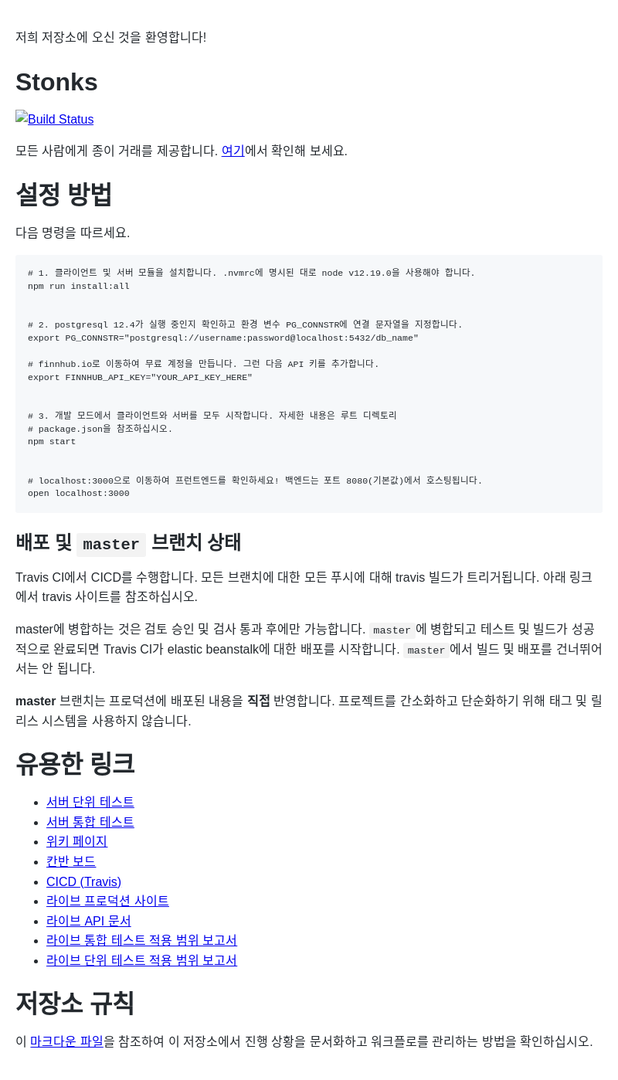

In [8]:
doc_dict = collection['test'][0]['doc']
document = Document.from_dict(doc_dict)
document.nodes[0].image

In [9]:
import json
documents = collection['test']['doc']
with open('cache/multimodal_messages/documents.json', 'w') as f:
    f.write(json.dumps({'documents': documents}, indent=4, ensure_ascii=False))

# 3. Chunk, Embed

## 3-1. Chunk Texts

In [10]:
from psiking.core.splitter.multimodal.it_langchain_text_splitters import ITLangchainRecursiveCharacterTextSplitter

splitter = ITLangchainRecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap = 128
)

In [11]:
chunks = []
for sample in tqdm(collection['test']):
    document = Document.from_dict(sample['doc'])
    
    document_chunks = []
    source_id = document.id_
    for i, node in enumerate(document.nodes):
        # Run Splitter
        if isinstance(node, ImageNode):
            try:
                split_nodes = splitter.run(node)
            except Exception as e:
                print(i, node)
                print(str(e))
                raise e
        else:
            split_nodes = [node]
        
        # Create New Document
        # print(len(document.nodes[0].text), "SPLIT:", len(split_nodes))
        for split_node in split_nodes:
            # Each Document contains single node
            chunk = Document(
                nodes=[split_node],
                metadata={
                    "source_id": source_id,
                    "docid": document.metadata['docid'],
                }
            )
            document_chunks.append(chunk)
    chunks.extend(document_chunks)
print(len(chunks))

100%|██████████| 1000/1000 [00:10<00:00, 95.76it/s]

1435


In [12]:
# node.image_resource.data

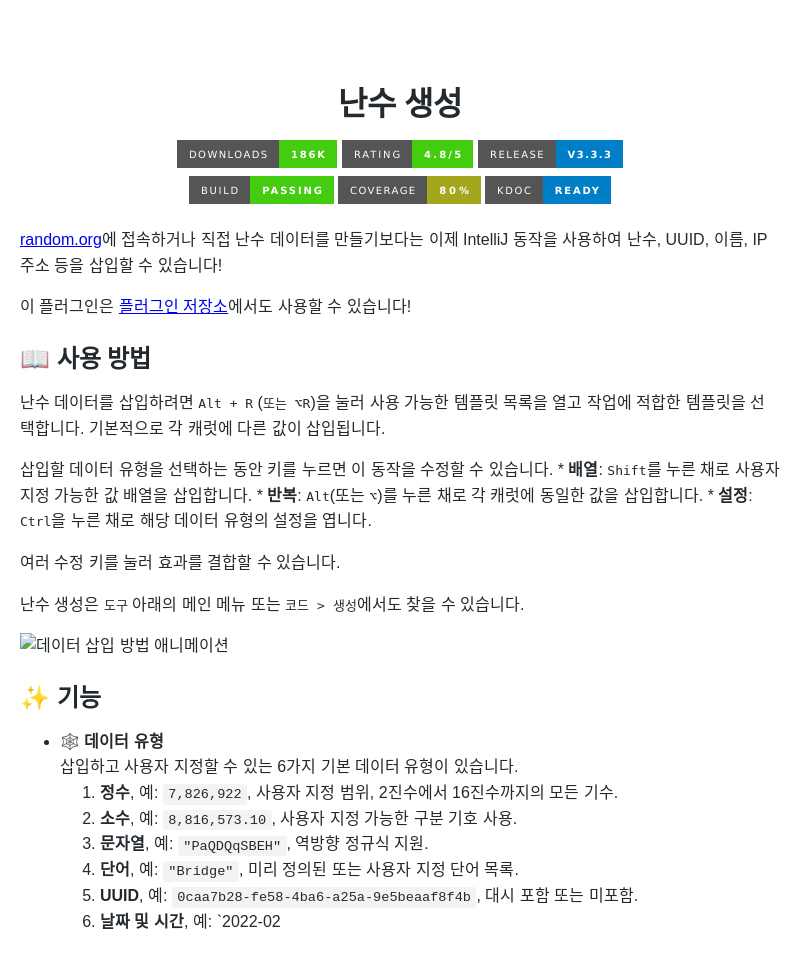

In [13]:
node.image

In [14]:
# Save Chunks (for testing)
import json
with open('cache/multimodal_messages/chunks.json', 'w') as f:
    f.write(
        json.dumps(
            {
              'chunks': [
                  x.to_dict() for x in chunks
              ]  
            },
            indent=4,
            ensure_ascii=False
        )
    )

## 3-2. Embed with jina-emb-v4

In [15]:
import asyncio
from tqdm.asyncio import tqdm

from psiking.core.embedder.vllm.online_jina_emb_v4 import VLLMOnlineJinaEmbV4Embedder

In [16]:
VLLM_ENDPOINT="http://localhost:8080"
MODEL="jina-embeddings-v4-vllm-retrieval"
embedder = VLLMOnlineJinaEmbV4Embedder(
    base_url=VLLM_ENDPOINT,
    model=MODEL
)

In [17]:
import base64
from io import BytesIO
from PIL import Image

def img_to_base64(img: Image.Image, format="PNG"):
    buffer = BytesIO()
    img.save(buffer, format=format)         # or format="JPEG"
    buffer.seek(0)

    # 3. Base64-encode
    b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return b64


text = node.text
# image_data = node.image_resource.data
# print(type(image_data))
# image_base64 = base64.b64encode(image_data).decode("utf-8")
# print(image_base64[:4])

image_base64 = img_to_base64(node.image)
messages = [
    {
        'role': 'user',
        'content': [
            {'type': 'text', 'text': text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image_base64}"}
            },
        ]
    }
]
embeddings = await embedder.arun(
    input = messages,
    input_format='messages',
    pool=True,
    normalize=True
)

In [18]:
import base64
from io import BytesIO
from PIL import Image

def img_to_base64(img: Image.Image, format="PNG"):
    buffer = BytesIO()
    img.save(buffer, format=format)         # or format="JPEG"
    buffer.seek(0)

    # 3. Base64-encode
    b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return b64

async def embed(semaphore, doc: Document):
    text = doc.nodes[0].text
    image_base64 = img_to_base64(doc.nodes[0].image)
    # image_data = doc.nodes[0].image_resource.data
    # image_base64 = base64.b64encode(image_data).decode("utf-8")
    messages = [
        {
            'role': 'user',
            'content': [
                {'type': 'text', 'text': text},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{image_base64}"}
                },
            ]
        }
    ]
    async with semaphore:
        embedding = await embedder.arun(
            input=messages,
            input_format='messages',
            pool=True,
            normalize=True
        )
    return embedding

In [19]:
semaphore = asyncio.Semaphore(32)

tasks = []
for chunk in chunks:
    task = embed(semaphore, chunk)
    tasks.append(task)

embeddings = await tqdm.gather(*tasks)

100%|██████████| 1435/1435 [29:51<00:00,  1.25s/it] 


In [20]:
print(len(embeddings))
print(len(embeddings[0]))

1435
2048


In [21]:
type(embeddings[0].tolist()[0])

float

# 4. Insert into VectorStore

In [22]:
from qdrant_client import QdrantClient
from psiking.core.storage.vectorstore.qdrant import QdrantSingleVectorStore

# initialize client
client = QdrantClient(host="localhost", port=6333)
collection_name = "jinavdr-github-multimodal-messages"

vector_store = QdrantSingleVectorStore(
    collection_name=collection_name,
    client=client
)

In [23]:
from qdrant_client.http import models

embedding_dim = 2048

vector_store.create_collection(
    on_disk_payload=True,  # store the payload on disk
    vectors_config = models.VectorParams(
        size=embedding_dim,
        distance=models.Distance.COSINE,
        on_disk=True,
    )
)

In [24]:
# np array -> List[float]
embeddings_float = [
    x.tolist() for x in embeddings
]

In [25]:
vector_store.add(
    documents=chunks,
    embeddings=embeddings_float,
    metadata_keys=["source_file", "docid"]
)

In [26]:
chunks[0].id_

'5dd6e597-c99d-4867-8bb6-fb59027f96ad'

In [27]:
points = vector_store._client.retrieve(
    collection_name=vector_store.collection_name,
    ids=[chunks[0].id_],
    with_vectors=True
)

In [28]:
print(points[0].id)
print(points[0].payload)
print(len(points[0].vector))

5dd6e597-c99d-4867-8bb6-fb59027f96ad
{'docid': 0}
2048


In [29]:
points[0]

Record(id='5dd6e597-c99d-4867-8bb6-fb59027f96ad', payload={'docid': 0}, vector=[0.0133120725, -0.026249502, 0.023728106, -0.017328931, 8.6503314e-05, -0.017702421, -0.0022716508, 0.029987348, -0.007236027, -0.020561812, -0.016617522, 0.01617345, -0.007063765, 0.025940102, -0.046584222, -0.020553658, 0.009475147, -0.007101384, 0.05681135, -0.027344756, -0.004889626, 0.0019554233, 0.026207443, -0.016798047, 0.028858349, -0.03313185, -0.046999242, -0.0054196524, 0.041042533, -0.013569739, 0.00020813115, -0.00044339432, 0.008699322, 0.019702218, -0.054075196, 0.000419011, -0.009162115, -0.020654917, -0.018558733, 0.013532144, -0.0032470506, 0.009217355, -0.012740973, -0.04525886, -0.019278944, -0.09504364, -0.025721658, -0.026067557, 0.0043651327, -0.03733798, 0.014706718, 0.007800676, -0.052750915, -0.011106454, -0.018217376, 0.04001712, 0.020165516, 0.0038634352, -0.01506697, 0.013217988, -0.003376334, 0.0048376382, 0.018535936, 0.004602429, 0.061627857, -0.011454387, 0.0138087915, 0.023